# 1. Tabular dataset -> Graph dataset


## 1.1 Homogeneous

All graph edges and nodes have the same type

We've used the [FIFA 21 Rating dataset](https://raw.githubusercontent.com/batuhan-demirci/fifa21_dataset), a dataset with soccer players.

At first we extract a small subset of thedata  to build a graph dataset.

In [23]:
import requests
import itertools

import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import networkx          as nx

from torch_geometric.data import Data
from torch_geometric.data import HeteroData


In [293]:
urls = [
    "https://raw.githubusercontent.com/batuhan-demirci/fifa21_dataset/master/data/tbl_player.csv",
    "https://raw.githubusercontent.com/batuhan-demirci/fifa21_dataset/master/data/tbl_player_skill.csv",
    "https://raw.githubusercontent.com/batuhan-demirci/fifa21_dataset/master/data/tbl_team.csv"
]

# Download files and store locally
for url in urls:
    filename = url.split("/")[-1]
    response = requests.get(url)
    with open(filename, "wb") as file:
        file.write(response.content)

# Load data
player_df = pd.read_csv("tbl_player.csv")
skill_df = pd.read_csv("tbl_player_skill.csv")
team_df = pd.read_csv("tbl_team.csv")

# Extract subsets
player_df = player_df[["int_player_id", "str_player_name", "str_positions", "int_overall_rating", "int_team_id"]]
skill_df = skill_df[["int_player_id", "int_long_passing", "int_ball_control", "int_dribbling"]]
team_df = team_df[["int_team_id", "str_team_name", "int_overall"]]

# Merge data
player_df = player_df.merge(skill_df, on='int_player_id')
fifa_df = player_df.merge(team_df, on='int_team_id')

# Sort dataframe
fifa_df = fifa_df.sort_values(by="int_overall_rating", ascending=False)
print("Players: ", fifa_df.shape[0])
fifa_df.head()


#We select only one team to improve visualization
fifa_df = fifa_df[fifa_df['str_team_name'] == "Liverpool"]
# fifa_df = fifa_df[:12]

Players:  18767


Let's first identify the graph-specific things we need:

- `Nodes` - Football players (by ID)
- `Edges` - If they play for the same team (see explanation below)
- `Node Features` - The football player's position, specialities, ball control, ...
- `Labels` - The football player's overall rating (node-level regression task)


Nodes are usually very straight-forward to identify - here we even have IDs.
If you don't have a unique identifier, you need one, because you need to know between which nodes a connection exists!

 The most challenging task is typically to link these nodes somehow through edges. Here we define the edges based on the team assignment. With this dataset, we could predict the expected rating when a player switches to a new team or a new player is observed. Therefore we expect relational effects through the team assignment. Of course there are many other possibilities to define the edges such as:
- How many times two players played together (edge weight) --> Synergies
- How many times a player has won/los 1:1 duels (edge weight)
- Started their career in the same football club
- Temporal edges: "Played together in the last 2 weeks"
- ...

As you can see, there are many choices how to combine instances in the dataframe. We will continue with the easiest approach, which is connecting them accoring to their team assignments.



Each football player ID occurs only once in our dataset.



> Note that we plan to build one single graph here! If individual node-id's occur more than once in your dataset, there are different options:

- You have multiple graphs that can contain the same node. In this case you need to iterate over each subset of your dataframe, that belongs to one individual graph and do the calculations on this subset
- You have to aggregate multiple rows into one. For example if you have transactional data (like a payment history), you would need to summarize this somehow into one feature vector, such as: #payments, payment amount, ...
- You have a temporal dataset and need to check section 2.)


`Step 4`: Extract the node features

The node features are typically represented in a matrix of the shape *(num_nodes, node_feature_dim)*.

For each of the football players, we simply extract their attributes. Because each player id is unique, we can easily do this based on the original dataframe. Have a look at the other examples in this notebook to see how an aggregation can look like if you have multiple rows for individual nodes.

In [294]:
# Sort to define the order of nodes
sorted_df = fifa_df.sort_values(by="int_player_id")
# Select node features
node_features = sorted_df[["str_positions", "int_long_passing", "int_ball_control", "int_dribbling"]]
# Convert non-numeric columns
pd.set_option('mode.chained_assignment', None)
positions = node_features["str_positions"].str.split(",", expand=True)
node_features["first_position"] = positions[0]
# One-hot encoding
node_features = pd.concat([node_features, pd.get_dummies(node_features["first_position"])], axis=1, join='inner')
node_features.drop(["str_positions", "first_position"], axis=1, inplace=True)
node_features.head()

,int_long_passing,int_ball_control,int_dribbling,CB,CDM,CF,CM,GK,LB,LW,RB,RM,RW,ST
7,44,30,27,False,False,False,False,True,False,False,False,False,False,False
8,75,89,90,False,False,False,False,False,False,False,False,False,True,False
9,71,89,91,False,False,False,False,False,False,True,False,False,False,False
10,86,77,70,True,False,False,False,False,False,False,False,False,False,False
30,89,87,77,False,False,False,False,False,False,False,True,False,False,False


In [295]:
# Convert to numpy
# Each row corresponds to one node in our final graph.
x = node_features.to_numpy()
x.shape # [num_nodes x num_features]

(32, 14)

Extract the labels ->  Ratings of each of the players.

In [296]:
# Sort to define the order of nodes
sorted_df = fifa_df.sort_values(by="int_player_id")
# Select node features
labels = sorted_df[["int_overall"]]
# Convert to numpy
y = labels.to_numpy()
print(y.shape) # [num_nodes, 1] --> node regression
labels.head()


(32, 1)


,int_overall
7,85
8,85
9,85
10,85
30,85


In [297]:
# Remap player IDs
fifa_df["int_player_id"] = fifa_df.reset_index().index

Each team corresponds to a fully-connected graph within each team-subgroup. The nodes are the players.

In [298]:
teams = fifa_df["str_team_name"].unique()
all_edges = np.array([], dtype=np.int32).reshape((0, 2))
1
for team in teams:
    team_df = fifa_df[fifa_df["str_team_name"] == team]
    players = team_df["int_player_id"].values
    # Build all combinations, as all players are connected
    permutations = list(itertools.combinations(players, 2))
    edges_source = [e[0] for e in permutations]
    edges_target = [e[1] for e in permutations]
    team_edges = np.column_stack([edges_source, edges_target])
    all_edges = np.vstack([all_edges, team_edges])

# Convert to Pytorch Geometric format
edge_index = all_edges.transpose()
# edge_index # [2, num_edges]


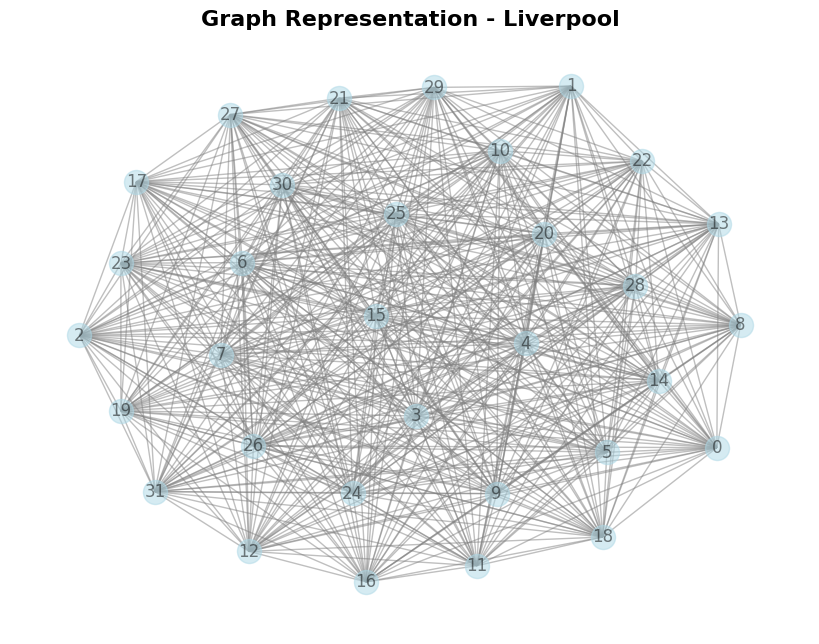

In [299]:
#Create grah structure with torch geometrics
data = Data(x=x, edge_index=edge_index, y=y)

#We convert to networkx graph so we can plot
G     = nx.Graph()
G.add_nodes_from(range(data.num_nodes))
edges = np.transpose(data.edge_index).tolist()   
G.add_edges_from(edges)

plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G)  
nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", alpha=0.5)
plt.title("Graph Representation - Liverpool", fontsize=16, fontweight="bold")
plt.show()

## 1.2 Heterogeneous

Graph edges and nodes have different types

On this case, we've used the [Anime Recommender Database](https://github.com/Mayank-Bhatia/Anime-Recommender) (a movie recommendation dataset).


In [54]:
urls = [
    "https://raw.githubusercontent.com/Mayank-Bhatia/Anime-Recommender/master/data/anime.csv",
    "https://raw.githubusercontent.com/Mayank-Bhatia/Anime-Recommender/master/data/rating.csv"
]

for url in urls:
    filename = url.split("/")[-1]
    response = requests.get(url)
    with open(filename, "wb") as file:
        file.write(response.content)

anime = pd.read_csv("anime.csv")
rating = pd.read_csv("rating.csv")

In [55]:
rating = rating.loc[rating['anime_id'].isin([9316, 5114,28977,6133,26081])]
users_to_select = [39532, 48766, 58483,3,10,20171,1,7,1001]
rating = rating[rating['user_id'].isin(users_to_select)]


In [56]:
rating.sort_values(by='user_id', ascending=False)

,user_id,anime_id,rating
6275552,58483,5114,9
6275796,58483,9316,1
5100254,48766,5114,-1
5100757,48766,6133,-1
5101979,48766,9316,-1
5105671,48766,26081,-1
5106033,48766,28977,-1
4169779,39532,5114,-1
4169844,39532,6133,-1
4170014,39532,9316,-1


In [57]:
rating['anime_id'].unique()

array([ 5114,  9316,  6133, 26081, 28977], dtype=int64)

In [58]:
anime = anime.loc[anime['anime_id'].isin([9316, 5114,28977,6133,26081])]

We have two tables - one that contains information about the movies and another one that describes how the users rated the movies.

In [59]:
anime.head()

,anime_id,name,genre,type,episodes,rating,members
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175
12293,26081,Yasuji no Pornorama: Yacchimae!!,Hentai,Movie,1,5.46,142


In [106]:
anime_dict = dict(zip(anime['anime_id'], anime['name']))

In [60]:
# A value -1 indicates that user has watched but has not rated the movie

rating.head()

,user_id,anime_id,rating
183,3,5114,10
1165,10,5114,10
2083634,20171,9316,7
4169779,39532,5114,-1
4169844,39532,6133,-1


Let's just like before first identify the graph entities we need.

- `Nodes` - Users and Animes
- `Edges` - If a user has rated a movie / the rating (edge weight)
- `Node Features` - The movie attributes and for the users we have no explicit features so we have to figure something out later
- `Labels` - The rating for a movie (link prediction regression task)

This dataset will, just like `Example 1` lead to one single graph that contains all nodes and edges. Given a pair of node and anime movie, we will be able to predict if / how the user likes this movie. To model this as a graph, we will have to support two node types: movie and user. That's because they have different node features (and shapes) that would not fit into one joint node feature matrix.


`Preprocessing one single graph...`

`Step 4`: Extract the node features

Each of the movies occurs only once in the anime dataframe and hence we can directly extract the features from there. If you have multiple entries for each node (movie ID) in your dataframe please have a look at the remarks at 1.1. (step 4).

We will just extract the columns with specific attributes and convert them to numeric features...

For the anime movies ...
- First we need to do a re-mapping of the IDs. That's because they don't start with 0 and also not all IDs are present. That's however important because the edge_index is always referring to the index in the node feature matrix
- We will store this mapping because we will need it later

In [61]:
# Sort to define the order of nodes
sorted_df = anime.sort_values(by="anime_id").set_index("anime_id")

# Map IDs to start from 0
sorted_df = sorted_df.reset_index(drop=False)
movie_id_mapping = sorted_df["anime_id"]

# Select node features
node_features = sorted_df[["type", "genre", "episodes"]]
# Convert non-numeric columns
pd.set_option('mode.chained_assignment', None)

# For simplicity I'll just select the first genre here and ignore the others
genres = node_features["genre"].str.split(",", expand=True)
node_features["main_genre"] = genres[0]

# One-hot encoding
anime_node_features = pd.concat([node_features, pd.get_dummies(node_features["main_genre"])], axis=1, join='inner')
anime_node_features = pd.concat([anime_node_features, pd.get_dummies(anime_node_features["type"])], axis=1, join='inner')
anime_node_features.drop(["genre", "main_genre"], axis=1, inplace=True)
anime_node_features.head(10)

,type,episodes,Action,Hentai,Movie,OVA,TV
0,TV,64,True,False,False,False,True
1,OVA,1,False,True,False,True,False
2,OVA,1,False,True,False,True,False
3,Movie,1,False,True,True,False,False
4,TV,51,True,False,False,False,True


In [62]:
# Convert to numpy
x = anime_node_features.to_numpy()
x.shape # [num_movie_nodes x movie_node_feature_dim]

(5, 7)

For the users ...

Here we are missing a dataframe that describes the attributes of each user. As a workaround we have different options:
- Either we insert dummies (for example random values between 0 and 1 like [0, 0.5, 0.1, 1]), which will then be updated through message passing
- Or we calculate some stats about the users, such as average rating, number of ratings, ... (based on the rating dataframe)
- Or we use typical characteristics of each node as features (degree, neighborhood, or even Node2Vec embedding)


We will go with the second option here.

```
Important: If you calculate statistics based on the dataframe, always make sure to first split into test and train set
in order to leak no information into the dataset! (I didn't do this here)
```



In [63]:
# Find out mean rating and number of ratings per user
mean_rating = rating.groupby("user_id")["rating"].mean().rename("mean")
num_rating = rating.groupby("user_id")["rating"].count().rename("count")
user_node_features = pd.concat([mean_rating, num_rating], axis=1)

# Remap user ID (to start at 0)
user_node_features = user_node_features.reset_index(drop=False)
user_id_mapping = user_node_features["user_id"]

# Only keep features
user_node_features = user_node_features[["mean", "count"]]
user_node_features.head()

,mean,count
0,10.0,1
1,10.0,1
2,7.0,1
3,-1.0,3
4,-1.0,5


In [64]:
# Convert to numpy
x = user_node_features.to_numpy()
x.shape # [num_user_nodes x user_node_feature_dim]

(6, 2)

Those are already our node feature matrices. We could of course also normalize the values to be in the range of (0,1).

For the movies we have clear attributes that describe each node. For the users we have calculated some basic properties that provide information about the rating behavior.

The number of nodes and the ordering is implicitly defined by their shape. Each row corresponds to one node in our final graph.

`Step 5`: Extract the labels

In this example, we have a link prediction / regression problem and thus the labels are the edges. The plot below shows the distribution of the ratings. Later the task will be to predict the ratings between a user and movie.

Unlike in `Example 1` the labels are now equal to the number of edges.



In [65]:
rating.head()

,user_id,anime_id,rating
183,3,5114,10
1165,10,5114,10
2083634,20171,9316,7
4169779,39532,5114,-1
4169844,39532,6133,-1


<Axes: >

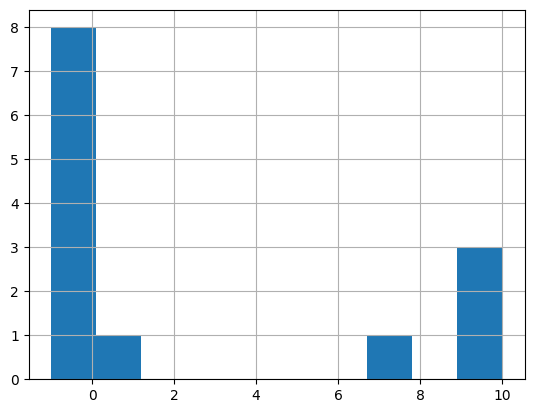

In [66]:
# -1 means the user watched but didn't assign a weight
rating["rating"].hist()

As you can see (below), we don't have all of the movies in the rating table (which is natural, because we usually don't have ratings for all items). This means, we don't have labels for all user-item pairs, but only a subset.

To consider this in the loss calculation, we can simply store a mask of the indices that are available. Previously I also quickly talked about masks, in the node-level prediction case. It is exactly the same here - we just want to perform predictions for the entities for which we have a label.

As we have an edge-prediction problem here, we implicitly stored this mask already as edge_index. For each edge we know the label and therefore we only have to calculate the loss based on the edges we know. Later at inference time, we can also predict the edge attributes (labels) for other node pairs.

In [67]:
# Movies that are part of our rating matrix
rating["anime_id"].unique()

array([ 5114,  9316,  6133, 26081, 28977], dtype=int64)

In [68]:
# All movie IDs (e.g. no rating above for 1, 5, 6...)
anime["anime_id"].sort_values().unique()

array([ 5114,  6133,  9316, 26081, 28977], dtype=int64)

In [69]:
# We can also see that there are some movies in the rating matrix, for which we have no features (we will drop them here)
print(set(rating["anime_id"].unique()) - set(anime["anime_id"].unique()))
rating = rating[~rating["anime_id"].isin([30913, 30924, 20261])]

set()


In [70]:
# Extract labels
labels = rating["rating"]
labels.tail()

5101979   -1
5105671   -1
5106033   -1
6275552    9
6275796    1
Name: rating, dtype: int64

In [71]:
# Convert to numpy
y = labels.to_numpy()
y.shape

(13,)

`Step 6`: Extract the edges

In this example, the edges are already implicitly provided by the rating matrix. The important part however is that we need to use the remappings from before to align the IDs of the dataframes.

For each entry in the matrix, we have exactly one edge, between the user_id and the anime_id. Therefore, the edge index is exactly the same as what we have calculated in the cell above.

The edge index can later be used in the model to mask out all edges for which we have no information.

In [72]:
print("Before remapping...")
rating.head()

Before remapping...


,user_id,anime_id,rating
183,3,5114,10
1165,10,5114,10
2083634,20171,9316,7
4169779,39532,5114,-1
4169844,39532,6133,-1


In [73]:
# Map anime IDs
movie_map = movie_id_mapping.reset_index().set_index("anime_id").to_dict()
rating["anime_id"] = rating["anime_id"].map(movie_map["index"]).astype(int)
# Map user IDs
user_map = user_id_mapping.reset_index().set_index("user_id").to_dict()
rating["user_id"] = rating["user_id"].map(user_map["index"]).astype(int)

print("After remapping...")
rating.head()

After remapping...


,user_id,anime_id,rating
183,0,0,10
1165,1,0,10
2083634,2,2,7
4169779,3,0,-1
4169844,3,1,-1


In [74]:
edge_index = rating[["user_id", "anime_id"]].values.transpose()
edge_index # [2 x num_edges]

array([[0, 1, 2, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5],
       [0, 0, 2, 0, 1, 2, 0, 1, 2, 3, 4, 0, 2]])

In [75]:
data = HeteroData()
data['user'].x = user_node_features
data['movie'].x = anime_node_features
data['user', 'rating', 'movie'].edge_index = edge_index
data['user', 'movie'].y = y

In [126]:
data['user', 'rating', 'movie']

{'edge_index': array([[0, 1, 2, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5],
       [0, 0, 2, 0, 1, 2, 0, 1, 2, 3, 4, 0, 2]]), 'y': array([10, 10,  7, -1, -1, -1, -1, -1, -1, -1, -1,  9,  1], dtype=int64)}

In [76]:
import networkx as nx
import torch

# Assuming you have the necessary data as described in the question

# Step 1: Extract node features
user_node_features = data['user'].x
movie_node_features = data['movie'].x

# Step 2: Extract edge indices and ratings
# edge_index = data['user', 'rating', 'movie'].edge_index
ratings = data['user', 'movie'].y

# Step 3: Create NetworkX bipartite graph
G = nx.Graph()


# Assuming user_node_features and movie_node_features are pandas DataFrame or Series
# movie_node_features.drop(columns=["type"], inplace=True)
movie_node_features = movie_node_features.select_dtypes(include=[np.number])
user_node_features = torch.tensor(user_node_features.values, dtype=torch.float)
movie_node_features = torch.tensor(movie_node_features.values, dtype=torch.float)

# Add user nodes with user features
for user_idx in range(len(user_node_features)):
    G.add_node(f"user_{user_idx}", bipartite=0, features=user_node_features[user_idx].tolist())

# Add movie nodes with movie features
for movie_idx in range(len(movie_node_features)):
    G.add_node(f"movie_{movie_idx}", bipartite=1, features=movie_node_features[movie_idx].tolist())


# Add edges with ratings
for i in range(len(edge_index[0])):
    user_idx = edge_index[0, i].item()
    movie_idx = edge_index[1, i].item()
    rating = ratings[i].item()
    G.add_edge(f"user_{user_idx}", f"movie_{movie_idx}", rating=rating)

# Step 4: Return the NetworkX bipartite graph
bipartite_graph = G


In [130]:
for n, d in G.nodes(data=True):
    print(n,d)

user_0 {'bipartite': 0, 'features': [10.0, 1.0]}
user_1 {'bipartite': 0, 'features': [10.0, 1.0]}
user_2 {'bipartite': 0, 'features': [7.0, 1.0]}
user_3 {'bipartite': 0, 'features': [-1.0, 3.0]}
user_4 {'bipartite': 0, 'features': [-1.0, 5.0]}
user_5 {'bipartite': 0, 'features': [5.0, 2.0]}
movie_0 {'bipartite': 1, 'features': []}
movie_1 {'bipartite': 1, 'features': []}
movie_2 {'bipartite': 1, 'features': []}
movie_3 {'bipartite': 1, 'features': []}
movie_4 {'bipartite': 1, 'features': []}


In [120]:
labels = {}
for n, d in G.nodes(data=True):
    if d['bipartite'] == 0:
        label = f"ID {user_id_mapping[int(n.split('_')[1])]}"
    else:
        label = f"{anime_dict[movie_id_mapping[int(n.split('_')[1])]].split(' ')[0]}"
    labels[n] = label

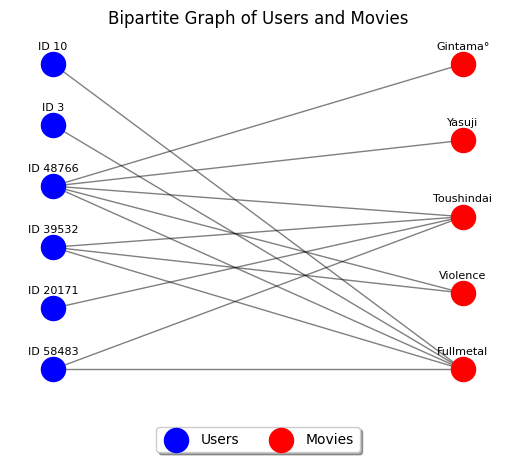

In [146]:
# Project the bipartite graph onto one of its node sets (e.g., users or movies)
user_nodes = {n for n, d in bipartite_graph.nodes(data=True) if d['bipartite'] == 0}
movie_nodes = {n for n, d in bipartite_graph.nodes(data=True) if d['bipartite'] == 1}

# Plot the bipartite graph
pos = nx.bipartite_layout(bipartite_graph, user_nodes)

# Draw user nodes
nx.draw_networkx_nodes(bipartite_graph, pos, nodelist=user_nodes, node_color='b', label='Users')

# Draw movie nodes
nx.draw_networkx_nodes(bipartite_graph, pos, nodelist=movie_nodes, node_color='r', label='Movies')

# Draw edges
nx.draw_networkx_edges(bipartite_graph, pos, width=1.0, alpha=0.5)

pos_label = {}
for posit in pos:
    pos_label[posit] = (pos[posit][0],pos[posit][1]+0.08)

nx.draw_networkx_labels(G, pos_label, labels=labels, font_size=8, font_color='black')
# Add labels and legend
plt.title('Bipartite Graph of Users and Movies')
# plt.legend()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
plt.axis('off')
plt.show()


# 2. Tabular dataset -> Temporal Graph dataset

In your tabular dataset identify the following:

- Nodes (Items, People, Locations, ...)
- Edges (Connections, Interactions, Correlations, ...)
- Node Features (Attributes)
- Labels (Node-level, edge-level, graph-level)
- Timesteps (Are they already defined? What is one timestep?) --> e.g. 60 min Interval
- Temporal graph shape: static or dynamic? / What is changing over time?

and optionally:
- Edge weights (Strength of the connection, number of interactions, ...)
- Edge features (Additional properties describing the edge)



`Example 3 / Step 3`

I selected a random time-series dataset from the internet, which we try to convert to a temporal graph dataset. The dataset contains the [trip history of bikers in New York City](https://ride.citibikenyc.com/system-data). Luckily the start end end locations already have an ID, otherwise we would have to map the addresses to locations.


In [394]:
import pandas as pd
!wget -q http://s3.amazonaws.com/tripdata/201306-citibike-tripdata.zip
!unzip -o 201306-citibike-tripdata.zip

trips = pd.read_csv("201306-citibike-tripdata.csv")
trips.head()

'wget' n�o � reconhecido como um comando interno
ou externo, um programa oper�vel ou um arquivo em lotes.


'unzip' n�o � reconhecido como um comando interno
ou externo, um programa oper�vel ou um arquivo em lotes.


FileNotFoundError: [Errno 2] No such file or directory: '201306-citibike-tripdata.csv'

In [ ]:
# Remove columns we don't need / rows with Nan
cols_to_drop = ["start station name", "end station name", ]
trips.dropna(inplace=True)
trips.drop(cols_to_drop, axis=1, inplace=True)
trips.head()

,tripduration,starttime,stoptime,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,695,2013-06-01 00:00:01,2013-06-01 00:11:36,444,40.742354,-73.989151,434.0,40.743174,-74.003664,19678,Subscriber,1983.0,1
1,693,2013-06-01 00:00:08,2013-06-01 00:11:41,444,40.742354,-73.989151,434.0,40.743174,-74.003664,16649,Subscriber,1984.0,1
3,123,2013-06-01 00:01:04,2013-06-01 00:03:07,475,40.735243,-73.987586,262.0,40.691782,-73.973730,16352,Subscriber,1960.0,1
4,1521,2013-06-01 00:01:22,2013-06-01 00:26:43,2008,40.705693,-74.016777,310.0,40.689269,-73.989129,15567,Subscriber,1983.0,1
6,2057,2013-06-01 00:02:33,2013-06-01 00:36:50,285,40.734546,-73.990741,532.0,40.710451,-73.960876,15693,Subscriber,1991.0,1


In [ ]:
# Reassign the location IDs (makes it easier later, because here the IDs didn't start at 0)
locations = trips['start station id'].unique()
new_ids = list(range(len(trips['start station id'].unique())))
mapping = dict(zip(locations, new_ids))

trips['start station id'] = trips['start station id'].map(mapping)
trips['end station id'] = trips['end station id'].map(mapping)
trips.head()

,tripduration,starttime,stoptime,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,695,2013-06-01 00:00:01,2013-06-01 00:11:36,0,40.742354,-73.989151,299,40.743174,-74.003664,19678,Subscriber,1983.0,1
1,693,2013-06-01 00:00:08,2013-06-01 00:11:41,0,40.742354,-73.989151,299,40.743174,-74.003664,16649,Subscriber,1984.0,1
3,123,2013-06-01 00:01:04,2013-06-01 00:03:07,1,40.735243,-73.987586,187,40.691782,-73.973730,16352,Subscriber,1960.0,1
4,1521,2013-06-01 00:01:22,2013-06-01 00:26:43,2,40.705693,-74.016777,257,40.689269,-73.989129,15567,Subscriber,1983.0,1
6,2057,2013-06-01 00:02:33,2013-06-01 00:36:50,3,40.734546,-73.990741,280,40.710451,-73.960876,15693,Subscriber,1991.0,1


**What could we use this dataset for?**

We could use it for example to predict the trip duration between two locations, based on the surrounding (structural) and temporal trip durations. Another possibility is to predict the bike traffic in terms of how many bikers we expect on a route.

- `Nodes` - The locations between which the bikers can travel
- `Node Features` - Attributes about a location, for example average number of bikers that start / end here, average traffic, ... (whatever is available)

For this dataset, we don't have edge (adjacency) information yet. This is often the difficult part with graph datasets. For traffic networks, you typically connect the nodes according to their closeness or even the underlying street network, i.e. if there is a direct road between two locations. Here we have the latitude/longitude for each of the addresses and with that we are able to calculate the distances.

- `Edges / Edge weights` - Proximity between two addresses (available) / Connection according to road network (not available here)
- `Edge features` - To incorporate the individual bike information, we can simply model this as edge features i.e. number of bikes, average trip duration, ...
- `Labels` - The trip duration, which makes it a link-prediction task

The more or less difficult part with temporal graph datasets, is to define a stepsize for the temporal snapshots. In the dataset above we have random trips from one location to another, without a pre-defined discrete interval.
An easy approach is for example to define X minute intervals and build a graph out of all trips that happened (ended) in this timeframe. The "ended" part is important, because we don't want to leak information into the future timesteps.

- `Timesteps` - 60 min steps (we have 1 month of data = ~ 700 graphs)



`Building the temporal dataset ...`

First make sure the dataset is sorted in time, so that we can iterate over the 60-min intervals.

In [ ]:
trips = trips.sort_values(by="starttime")
trips.head()

,tripduration,starttime,stoptime,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,695,2013-06-01 00:00:01,2013-06-01 00:11:36,0,40.742354,-73.989151,299,40.743174,-74.003664,19678,Subscriber,1983.0,1
1,693,2013-06-01 00:00:08,2013-06-01 00:11:41,0,40.742354,-73.989151,299,40.743174,-74.003664,16649,Subscriber,1984.0,1
3,123,2013-06-01 00:01:04,2013-06-01 00:03:07,1,40.735243,-73.987586,187,40.691782,-73.973730,16352,Subscriber,1960.0,1
4,1521,2013-06-01 00:01:22,2013-06-01 00:26:43,2,40.705693,-74.016777,257,40.689269,-73.989129,15567,Subscriber,1983.0,1
6,2057,2013-06-01 00:02:33,2013-06-01 00:36:50,3,40.734546,-73.990741,280,40.710451,-73.960876,15693,Subscriber,1991.0,1


Now we want to iterate over the dataframe and select all trips that fall into each of the 60 min intervals.

Just a quick check - how many trips per bucket will we end up with in the end? This defines for how many edges we have information in each individual graph


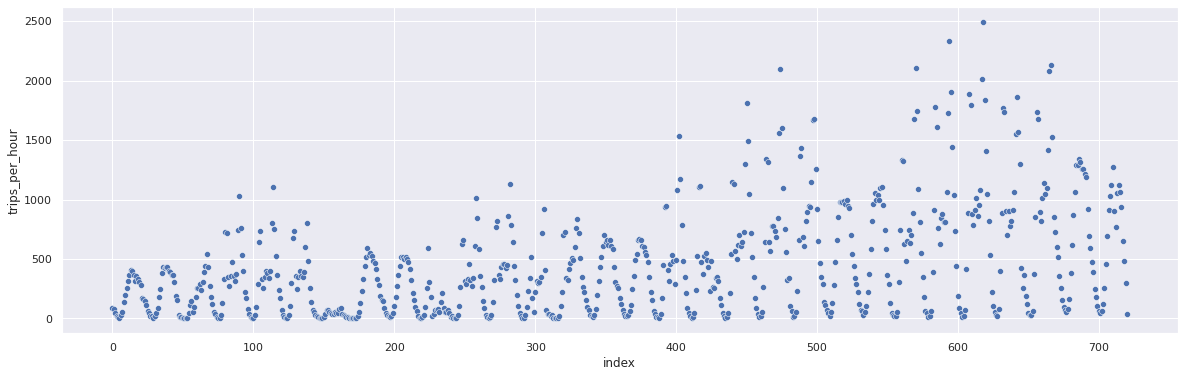

In [ ]:
from datetime import datetime, timedelta
import seaborn as sns
sns.set(rc={'figure.figsize':(20,6)})

# Convert columns to datetime
trips["starttime"] = pd.to_datetime(trips["starttime"], format="%Y-%m-%d %H:%M:%S")
trips["stoptime"] = pd.to_datetime(trips["stoptime"], format="%Y-%m-%d %H:%M:%S")

start_date = datetime.strptime("2013-06-01 00:00:01", "%Y-%m-%d %H:%M:%S")
end_date = datetime.strptime("2013-07-01 00:10:34", "%Y-%m-%d %H:%M:%S")
interval = timedelta(minutes=60)
bucket_elements = []
while start_date <= end_date:
    # Check how many trips fall into this interval
    bucket_elements.append(trips[((start_date + interval) >= trips["stoptime"])
                                  & (start_date <= trips["stoptime"])].shape[0])
    # Increment
    start_date += interval

sns.scatterplot(x="index", y="trips_per_hour", data=pd.DataFrame(bucket_elements, columns=["trips_per_hour"]).reset_index())

Chosing the right interval-size is an important design decision in temporal models. If it's too large, we will aggregate to much information and lose the fine grained information over time. If it's too small, we have a lot of noise in the data and the model might not be able to identify clear patterns.

We can see a clear trend here - at night there are way less bikers on the streets. Also, it seems that there is a global trend, which results in more and more bikers in total over time (probably because the weather is getting warmer).

So is this the right step-size? We can't really say yet - we have to try it out. But what we can see is that the number of bikers slowly changes over the day and therefore we probably don't aggregate too much information. Feel free to play around with the stepsize above - enter for example 600 (= 10 hours) or 10 (= 10 mins). Eventually it's also important to consider how far in the future we want to predict later.

`Step 4`: Extract the node features


**What type of temporal GNN dataset do I have?**

Another important point is how our graph changes over time. It can happen, that not all nodes are present in the next time-step, which makes it a bit difficult as our edge indices are shifted. Below I have some hints on how to cope with each of the graph types.

`Static Graph Temporal Signal`

This is simply a graph that always stays the same and only the label information changes. Common examples are road networks (the nodes/edges do not suddently disappear in a long-range time horizon) or electricity networks.
For this we can either use [pytorch geometric temporal](https://pytorch-geometric-temporal.readthedocs.io/en/latest/notes/installation.html) or also only [pytorch geometric](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.TemporalData), which recently added temporal graph support (but only dynamic edges).

This is by far the easiest graph type, because the node feature matrix and edge_index stay untouched. We only have to adjust the labels in each graph snapshot.

`Dynamic Graph Temporal/Static Signal`

The more difficult graph type is a dynamic graph (with regards to nodes/edges).
This typically happens in social networks, that quickly grow/shrink over time, but also transaction systems like crypto networks.
Previously I mentioned that the node ordering is implicitly defined by the node feature matrix - but what if this matrix changes.

`Option 1` 😸

The easiest solution is just to append new nodes (in it's temporal order at preprocessing-time) to this matrix and always use the full matrix (all nodes) even if not all of them are part of the current snapshot. This matrix can (depending on your nodes) get very big. Therefore I suggest to check what your maximum number of nodes is and if it's feasible to store your total node_feature matrix in memory.
If your node_features change over time, that's also no problem - you can simply update the node feature matrix for each snapshot. The important point for this option is that the ordering of the nodes always stays the same! This means index 0 is always the same node (e.g. location), even if it's not really used in this snapshot.


`Option 2` 😵

Option 1 will lead to a very big matrix with a lot of redundancies - but has one advantage: You always have the same index for a specific node. It can happen that a single node only occurs once and then is carried through all other snapshots, even if it's never used again. If you want to make your graph *really* dynamic, you should also be able to remove nodes. This however will affect the edge_index, because the indices of the node_feature matrix change!
Therefore we would need to re-index the edge_index to point to the correct nodes. But besides this there is another issue.

In spatio-temporal GNN models, you typically update the node feature embeddings over time (with a recurrent unit). The problem really is that you need to update nodes between two snapshots, based on their indices -> But what if a node is not present anymore. So as you can see it's not that trivial to learn on a dynamic graph. Therefore I'd suggest to make the first Option work. :)


---

In our case we have a `Static Graph Temporal Signal`, because our locations/edges do not really change over time. But as we will see later, when incorporating the labels as edge_features (for historical snapshots), we will end up with a `Dynamic Graph Temporal Signal`.


> Coming back to the node features...

We don't really have information about the nodes (locations) here but we need them in order to apply message passing. If really nothing comes to your mind, I would probably assign random values (gaussian samples) to the node feature matrix.

Here we can model the outgoing / incoming traffic as an attribute for the nodes. This allows us to say "this is a heavily frequented location" or not.
We can calculate this information based on the dataset, but here it's always important to consider that we should apply a train/test split in advance (which I didn't do here) to leak no information into the train set.


In [ ]:
import numpy as np
# Find out how many outgoing bikers we have
outgoing_trips = trips.groupby("start station id").count()["bikeid"].values
incoming_trips = trips.groupby("end station id").count()["bikeid"].values

# Normalize features between 0 and 1
outgoing_trips = (outgoing_trips - np.min(outgoing_trips)) / (np.max(outgoing_trips) - np.min(outgoing_trips))
incoming_trips = (incoming_trips - np.min(incoming_trips)) / (np.max(incoming_trips) - np.min(incoming_trips))

# Build node features
node_features = np.stack([outgoing_trips, incoming_trips]).transpose()
print("Full shape: ", node_features.shape)
node_features[:10] # [num_nodes x num_features]

Full shape:  (337, 2)


array([[0.76524844, 0.79829787],
       [0.39452544, 0.36964539],
       [0.16691461, 0.18751773],
       [0.92740256, 0.86297872],
       [0.6155906 , 0.62014184],
       [0.27700089, 0.28028369],
       [0.62600417, 0.62099291],
       [0.27848855, 0.22978723],
       [0.12734305, 0.11177305],
       [0.2692651 , 0.24879433]])

That's a simple example for a possible node feature matrix. As already mentioned - you can be creative here. :)

`Step 5`: Extract the edges

As mentioned previously, we want to create the edges based on the distances of the locations, as this is all information we have in this dataset. The hope is, that the GNN can later identify "crowded" places, where the tripduration will most likely take longer (due to traffic).

The topology of our graph is therefore **static** in this dataset, because the edges don't change and also the nodes are always the same. Therefore we can pre-compute this part of the graph. In fact, the only temporal part here are the labels (tripdurations), as we will see further below.

Therefore, we only calculate the edges once here for all snapshots. This can be efficiently done by building all combinations (the cartesian product) and applying the distance calculation on each row. **Remember: when dealing with dataframes there is almost always a better way than using a for-loop** 😀

But there was one problem I encountered during modelling the labels. I planned to use past labels (aka historical trip durations) as edge features, as this will add a lot of information to the graph. This basically tells us "this is the current trip duration for some parts of the graph (edge features), please predict 1 hour into the future for other parts of the graph" (labels).
Edge features however can only "live" on existing edges and unfortunately the static edges here (based on the location) are different from the bike-trips (which are not distance-based). Because of that I will extend the edge index later by the edges for the bike trips and will use edge features to signal that these added edges have different properties than the once I add here.
Consequentely, we will use a `Dynamic Graph Temporal Signal` later.
Note that this situation comes from the fact that we have two edges types - one for the distance-based edges and one for the trips. We could also model this as a heterogeneous graph instead of providing the information as edge features.


> Edge feats: [distance, edge_type, historical trip duration]





In [ ]:
from sklearn.utils.extmath import cartesian
from geopy.distance import geodesic

# Get all possible start locations and their geo info
subset = ["start station longitude", "start station latitude", "start station id"]
all_starts = trips.drop_duplicates(subset="start station id", keep="first")[subset]
# Get all possible end locations and their geo info
subset = ["end station longitude", "end station latitude", "end station id"]
all_ends = trips.drop_duplicates(subset="end station id", keep="first")[subset]
# Combine all combinations in one dataframe
distance_matrix = all_ends.merge(all_starts, how="cross")
distance_matrix["distance"] = distance_matrix.apply(lambda x: geodesic((x["start station latitude"], x["start station longitude"]),
                                                          (x["end station latitude"], x["end station longitude"])).meters, axis=1)
distance_matrix.head()

,end station longitude,end station latitude,end station id,start station longitude,start station latitude,start station id,distance
0,-74.003664,40.743174,299,-73.989151,40.742354,0,1229.224446
1,-74.003664,40.743174,299,-73.987586,40.735243,1,1618.732623
2,-74.003664,40.743174,299,-74.016777,40.705693,2,4307.215223
3,-74.003664,40.743174,299,-73.990741,40.734546,3,1452.477060
4,-74.003664,40.743174,299,-73.983799,40.726218,118,2522.253218


Based on the new "distance" column we can now create edges. For this we can select a threshold to only connect nodes that are close to each other. Alternatively, you can also take all edges and assign a weight to each edge in the graph.

The distance column is based on meters and here I'll just use 500 meteres as a cutoff (simply plot a histogram to find a good threshold). This will also generate self-loops (if you dont want that, simply also add > X).

In [ ]:
distance_matrix["edge"] = distance_matrix["distance"] < 500
distance_matrix.head()

,end station longitude,end station latitude,end station id,start station longitude,start station latitude,start station id,distance,edge
0,-74.003664,40.743174,299,-73.989151,40.742354,0,1229.224446,False
1,-74.003664,40.743174,299,-73.987586,40.735243,1,1618.732623,False
2,-74.003664,40.743174,299,-74.016777,40.705693,2,4307.215223,False
3,-74.003664,40.743174,299,-73.990741,40.734546,3,1452.477060,False
4,-74.003664,40.743174,299,-73.983799,40.726218,118,2522.253218,False


Now we are almost there! We just need a way to build the edge_index. For this, we need to consider the original ordering in the node feature matrix. Remember when we did the mapping of the indices before? - Because of that we already have the edge indices set.

In [ ]:
# Use mask to extract static edges
edge_index = distance_matrix[distance_matrix["edge"] == True][["start station id", "end station id"]].values
edge_index = edge_index.transpose()
edge_index # [2 x num_edges]

array([[  4,   6,  15, ..., 315, 317, 327],
       [299, 299, 299, ..., 272, 272, 272]])

In [ ]:
# Add edge features to indicate edge type
distance_feature = distance_matrix[distance_matrix["edge"] == True]["distance"].values
edge_type_feature = np.zeros_like(distance_feature) # 0 = static edge
trip_duration_feature = np.zeros_like(distance_feature) # 0 = no information
static_edge_features = np.stack([distance_feature, edge_type_feature, trip_duration_feature]).transpose()
static_edge_features # [num_edges x num_features]

array([[294.92884499,   0.        ,   0.        ],
       [327.27388739,   0.        ,   0.        ],
       [419.30404213,   0.        ,   0.        ],
       ...,
       [379.44132958,   0.        ,   0.        ],
       [349.85678078,   0.        ,   0.        ],
       [332.80260533,   0.        ,   0.        ]])

`Step 6`: Extract the labels and build the dataset

Now we get in touch with the temporal aspect of our dataset. Because the edge_index and the node features were static, we could pre-compute them for each snapshot. The labels however change over time, because we have different trip durations for different bikers for each 60 min interval. In addition to that we can also use historical labels as edge features. This is a special attribute of time-series datasets - the labels become features for past timesteps. If you have a node-level prediction task you can add the historical labels as node features to each of the nodes. But this also means that you cannot pre-compute the node feature matrix and need to do it in the following loop instead.

> In most of the time-series libraries this is called a "lag" or "offset". In our dataset we want to predict 1 hour into the future, based on the current situation (trip durations). Therefore, we can use the current trip durations as edge features and the trip durations of the next snapshot as targets. Of course you could also define a larger offset, for example 12 hours into the future.

As mentioned previously, we have to types of edges now - static edges based on the location and edges for historical trips (for which we need to insert new edges to use the edge features). It can happen that we have multiple bikers on the same "edge" (=route) - here we simply average all of the trip durations between two nodes.

Generally, everything that is temporal needs to be computed in a loop over the time-series. Because of that, we loop over the start and end time of our dataset and store the labels of each subsequent snapshot in a list and the current trip durations as edge features in another list.
We also stack the pre-computed node_features and edge_index, so that the first entry in each list corresponds to the first snapshot and so on. That's at least how it is typically done in [pytorch geometric temporal](https://pytorch-geometric-temporal.readthedocs.io/en/latest/index.html). Note that there is also a TemporalData Object in plain PyG available now.



In [ ]:
def extract_dynamic_edges(s):
    # Extract dynamic edges and their features
    trip_indices = s[["start station id", "end station id"]].values
    trip_durations = s["tripduration"]

    # Build edge features
    distance_feature  = pd.DataFrame(trip_indices,
                                    columns=["start station id", "end station id"]).merge(
                                        distance_matrix, on=["start station id", "end station id"],
                                        how="left")["distance"].values
    edge_type_feature = np.ones_like(distance_feature) # 1 = dynamic
    trip_duration_feature = trip_durations
    edge_features = np.stack([distance_feature, edge_type_feature, trip_duration_feature]).transpose()
    return edge_features, trip_indices.transpose()



start_date = datetime.strptime("2013-06-01 00:00:01", "%Y-%m-%d %H:%M:%S")
end_date = datetime.strptime("2013-07-01 00:10:34", "%Y-%m-%d %H:%M:%S")
interval = timedelta(minutes=60)

xs = []
edge_indices = []
ys = []
y_indices = []
edge_features = []


while start_date <= end_date:
    # 0 - 60 min
    current_snapshot = trips[((start_date + interval) >= trips["stoptime"])
                                  & (start_date <= trips["stoptime"])]
    # 60 - 120 min
    subsequent_snapshot = trips[((start_date + 2*interval) >= trips["stoptime"])
                                  & (start_date + interval <= trips["stoptime"])]
    # Average duplicate trips
    current_snapshot = current_snapshot.groupby(["start station id", "end station id"]).mean().reset_index()
    subsequent_snapshot = subsequent_snapshot.groupby(["start station id", "end station id"]).mean().reset_index()

    # Extract dynamic trip edges
    edge_feats, additional_edge_index = extract_dynamic_edges(current_snapshot)
    exteneded_edge_index = np.concatenate([edge_index, additional_edge_index], axis=1)
    extended_edge_feats = np.concatenate([edge_feats, static_edge_features], axis=0)

    # Labels
    y = subsequent_snapshot["tripduration"].values
    y_index = subsequent_snapshot[["start station id", "end station id"]].values

    # Append everything
    xs.append(node_features) # static
    edge_indices.append(exteneded_edge_index) # static + dynamic
    edge_features.append(extended_edge_feats) # static + dynamic
    ys.append(y) # dynamic
    y_indices.append(y_index.transpose()) # dynamic

    # Increment
    start_date += interval

Ok so what did we just do here?

After each 60 min interval, we get a subset of our dataframe for this time range. Based on that, we extract all the available edge labels between two locations. Those are the ones we want to predict later in the model.
In order to calculate the loss only based on the edges for which we have labels, we store some sort of mask (y_index) that tells us for which source/target pairs we have labels.

> Important: Here we take the label of each snapshot as target value.

We could of course also normalize the labels to ensure smoother training for the regression setup.


**Now we have everything we need! 🎉**

In [ ]:
i = 2
print(f"""Example of graph snapshot {i}: \n
      Node feature shape: {xs[i].shape} \n
      Edge index shape: {edge_indices[i].shape} \n
      Edge feature shape: {edge_features[i].shape} \n
      Labels shape: {ys[i].shape} \n
      Labels mask shape: {y_indices[i].shape}
      """)

Example of graph snapshot 2: 

      Node feature shape: (337, 2) 

      Edge index shape: (2, 2773) 

      Edge feature shape: (2773, 3) 
 
      Labels shape: (25,) 

      Labels mask shape: (2, 25)
      


Just like before, I won't install Pytorch Geometric Temporal here, as this will make the notebook too heavy, but here are some code snippets for the final steps.


We need to pass the lists of numpy arrays to the Data Structures, as for example done [here](https://pytorch-geometric-temporal.readthedocs.io/en/latest/_modules/torch_geometric_temporal/dataset/wikimath.html#WikiMathsDatasetLoader).

```
from torch_geometric_temporal.signal import DynamicGraphTemporalSignal
dataset = DynamicGraphTemporalSignal(
            edge_indices, edge_features, xs, ys, y_indices=y_indices
        )

```

For more details please have a look [at the documentation](https://pytorch-geometric-temporal.readthedocs.io/en/latest/modules/signal.html).


# 3. Other questions / Final Remarks

-  `Note: I've seen that PyG has also added a helpful tutorial`
[You can find it here.](https://https://pytorch-geometric.readthedocs.io/en/latest/notes/load_csv.html)


- I would always put each of the calculations of node_features, labels, edge_indices ect. into separate functions

- What if I have pairs of graphs (graph matching ect.) --> use Pytorch Geometrics `PairData` as described [here](https://pytorch-geometric.readthedocs.io/en/latest/notes/batching.html#pairs-of-graphs).

- What if I want to represent images as graphs? --> Generally I think it's not a good idea to represent each pixle as a node, as this would require a lot of Message passing layers to learn the full image information. Instead, I'd suggest to divide the image into smaller patches (like 3x3 kernels) and represent those as nodes. The edges are then simply calculated based on the neighboring patches.

- How do I use images as nodes? --> In this case I would either convert the 2D images to a 1D feature vector with a pretrained image model such as InceptionNet or would build a custom layer that applies a transformation to the images before doing message passing